# Prévalence de Listeria dans le lait cru

On dispose d'une base de données csv comportant 2 colonnes et 91 lignes, chaque ligne représentant un pays. 


La colonne 1 indique le nombre de cas de listeria recensés dans ce pays.

La colonne 2 indique le nombre d'échantillons testé dans ce pays.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from math import factorial
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

from tqdm import tqdm

In [2]:
## importation des données
data_frame = pandas.read_csv(r"listeria.csv", header=None)
data = data_frame.values
N_data = data.shape[0]

Text(0, 0.5, 'nombre de pays')

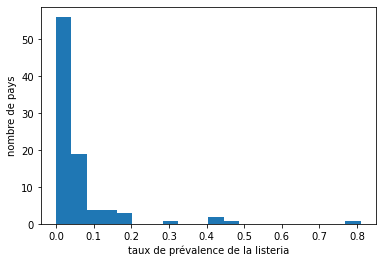

In [104]:
## Répartition des probabilité de positivité dans l'échantillon
proba_positif = [r/n for (r,n) in data]
proba_positif_corrige = [a for a in proba_positif if a!=0]
plt.hist(proba_positif, bins=20, log=False)
plt.xlabel("taux de prévalence de la listeria")
plt.ylabel("nombre de pays")

Quelques fonctions utiles :

In [4]:
# liste des logarithmes des coefficients binomiaux utilisés 
# dans le calcul de la logvraisemblance (Q1): 

def log_fact(n) :
    res = 0
    for i in range(int(n)) :
        res+= np.log(i+1)
    return res

def log_binomial(n, r):
    return log_fact(n) - log_fact(r) - log_fact(n-r)

list_log_bin = [log_binomial(data[i][1],data[i][0]) for i in range(N_data)]

In [5]:
## loi Beta : donne le logarithme de la fonction densité d'une loi beta, 
## de paramètres alpha et beta, à une constante près

def log_beta(x,alpha,beta) :
    res = 0
    if alpha >= 1 :
        res += (alpha-1)*np.log(x)
    if beta >= 1 :
        res += (beta-1)*np.log(1-x)
    return res

## Question 1

On suppose dans cette partie que le nombre d'échatillons testés positifs dans un pays suit une loi $r_i \sim B(n_i,p) $ où $n_i$ est le nombre total d'échantillon testés et le paramètre $p$, **identique pour tous les pays** suit une loi $p \sim Beta(\alpha,\beta)$ avec $\alpha = \beta = 1$.

Nous cherchons à déterminer la loi de $p$ à postériori

In [108]:
Alpha = 1
Beta = 1

In [109]:
## vraisemblance
def log_likelihood(p) :
    res = 0
    for i in range(N_data) :
        r,n = data[i] 
        res += list_log_bin[i] + r*np.log(p) + (n-r)*np.log(1-p)
    return res

In [110]:
## calcul de la loi de p a posteriori
def log_loi_posteriori(p) :
    return log_likelihood(p) + log_beta(p,Alpha,Beta)

### représentation du logarithme de la loi a posteriori
$\pi_{N}  \propto \mathcal{B}eta(91\bar{r}+1, 91(\bar{n}-\bar{r})+ 1)$

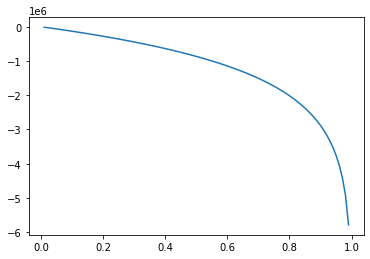

In [111]:
## représentation
n_pts = 100
X = np.linspace(1/n_pts,1,n_pts,endpoint=False)
Y = log_loi_posteriori(X)
plt.plot(X,Y)
#plt.axes(ylim = (-0.01,0.01))
plt.show()

représentation du logartihme d'une loi Beta de paramètres $(91\bar{r}+1; 91(\bar{n}-\bar{r})+ 1)$ 

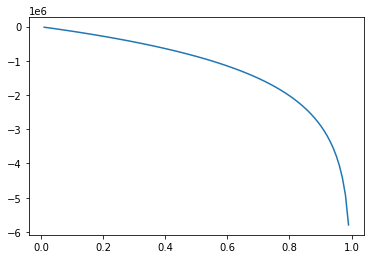

In [112]:
r_bar = np.mean(data[:,[0]])
n_bar = np.mean(data[:,[1]])
Z = log_beta(X,N_data*r_bar+1,N_data*(n_bar-r_bar)+1)
plt.plot(X,Z)
plt.show()

#### Comparaison probabilités simulées et probabilités estimées

In [114]:
sample = np.random.beta(N_data*r_bar+1,N_data*(n_bar-r_bar)+1, size=N_data)

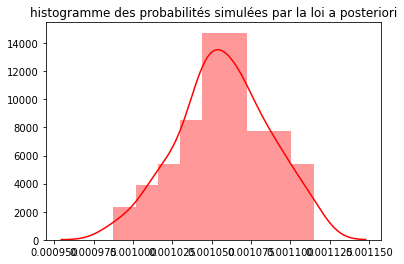

In [121]:
plt.title('histogramme des probabilités simulées par la loi a posteriori')
sns.distplot(sample, color="red", kde=True)

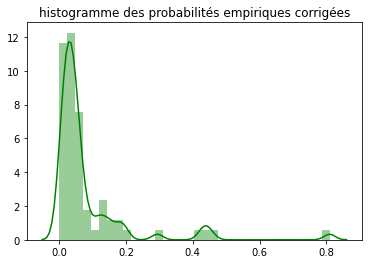

In [122]:
plt.title('histogramme des probabilités empiriques corrigées')
sns.distplot(proba_positif_corrige, color="green", kde=True)

## Question 2

On suppose dans cette partie que le nombre d'échatillons testés positifs dans un pays suit une loi $r_i \sim B(n_i,p_i) $ où le paramètre $p_i$, **est propre à chaque pays et** suit une loi $p_i \sim Beta(\alpha,\beta)$ 

On pose $\mu = \frac{\alpha}{\alpha+\beta}$ et $\kappa = \alpha + \beta$

On suppose à priori $\mu \sim U([0,1])$ et $\kappa \sim Exp(0.1)$

Nous cherchons à simuler la loi de $p, \mu$ et $\kappa$ à posteriori

#### Loi a posteriori de l'un des $p_i$ sachant $\mu$, $\kappa$ et les données :

$ \pi_{p_j | \kappa, \mu, p_{-j}} \propto \big( p_j^{r_j - 1 + \kappa\mu}(1-p_j)^{n_j - r_j -1 + \kappa(1-\mu)} \big) 1(p_j \in [0,1])$

On observe que $p_i$ est indépendant de $p_{-i}$ et :

$p_{i}| \mu,\kappa \sim B(r_{i}+\mu\kappa , n_{i}+\kappa(1-\mu)-r_{i}) $

In [10]:
def Step_pi(i,mu,kappa) :
    r,n = data[i]
    return np.random.beta(r + mu*kappa, n - r + kappa*(1-mu))

#### Loi a posteriori de $\mu$ sachant $\kappa$, le vecteur des $p_i$ et les données :

$\pi_{\mu | \kappa, p} \propto \prod_i p_i^{\kappa\mu}(1-p_i)^{\kappa(1-\mu)} 1(\mu \in [0,1])$

In [11]:
def log_loi_mu(vect_p, mu, kappa) :
    res = 0
    accept = True
    
    if mu<=0 or mu>=1 :
        accept = False
    else :
        for i in range(N_data) :
            p = vect_p[i]
            if p < 10**(-15) :
                res += -15*kappa*mu
            else :
                res += kappa*mu*(np.log(p) - np.log(1-p))
            
    return (accept, res)

In [12]:
def Metropolis_step_mu(vect_p, mu, kappa) :

    local_mu = mu
    # simulation d'un nouveau mu à partir du premier
    mu_new = np.random.normal(mu, 0.2)
    
    Loi = log_loi_mu(vect_p, mu_new, kappa)
    if Loi[0] :
        
        log_taux_acceptation = Loi[1] - log_loi_mu(vect_p, mu, kappa)[1]
    
        if np.log(np.random.random()) <= log_taux_acceptation:
            #print("mu accept")
            local_mu = mu_new
            
    return local_mu

#### Loi a posteriori de $\kappa$ sachant $\mu$, le vecteur des $p_i$ et les données :

$\pi_{\kappa | \mu, p} \propto \big( \prod_i p_i^{\kappa\mu}(1-p_i)^{\kappa(1-\mu)} \big) \exp(-0.1\kappa)1(p_j \geq 0)$

In [13]:
def log_loi_kappa(vect_p, mu, kappa) :
    res = 0
    accept = True
    
    if kappa<=0 :
        accept = False
    else :
        for i in range(N_data) :
            p = vect_p[i]
            if p<10**(-15) :
                res += -15*kappa*mu
            else :
                res += kappa*mu*np.log(p) + kappa*(1-mu)*np.log(1-p)
        res -= 0.1*kappa
        
    return (accept, res)

In [14]:
def Metropolis_step_kappa(vect_p, mu, kappa) :

    # simulation d'un nouveau kappa à partir du premier
    kappa_new = np.random.normal(kappa, 0.3)
    
    Loi = log_loi_kappa(vect_p, mu, kappa_new)
    if Loi[0] :
        
        log_taux_acceptation = Loi[1] - log_loi_kappa(vect_p, mu, kappa)[1]
    
        if np.log(np.random.random()) <= log_taux_acceptation:
            #print("kappa accept")
            kappa = kappa_new
    
    return kappa

### Simulation avec Metropolis within Gibbs

In [15]:
def Metropolis_Gibbs(mu,kappa) :
    
    vect_p = np.zeros(N_data)
    for i in range(N_data) :
        vect_p[i] = Step_pi(i,mu,kappa)
    
    mu = Metropolis_step_mu(vect_p, mu, kappa)
    kappa = Metropolis_step_kappa(vect_p, mu, kappa)
    
    return (vect_p,mu,kappa)

La fonction simulation renvoie une réalisation de la simulation avec l'algorithme Metropolis-Gibbs. 

La variable *n_pts* est le nombre de pas de simulation 

La variable *lap* est le nombre de pas entre deux réalisation non corrélées

L'algorithme renvoie toutes les valeurs simulées multiples de *laps*

In [16]:
def simulation(n_pts, laps, mu = 0.5, kappa = 0.1) :

    liste_p = []
    liste_mu = []
    liste_kappa = []
    
    sim_mu = mu
    sim_kappa = kappa

    compte = 0

    for i in range(n_pts*laps) :
    
        sim_p, sim_mu, sim_kappa = Metropolis_Gibbs(sim_mu, sim_kappa)
    
        if compte%laps == laps-1 :
            liste_p.append(sim_p)
            liste_mu.append(sim_mu)
            liste_kappa.append(sim_kappa)
        compte+=1
    
    return (np.array(liste_p), np.array(liste_mu), np.array(liste_kappa))

In [17]:
def estimation(n_pts, laps, mu=0.5, kappa = 0.1) :
    arr_p, arr_mu, arr_kappa = simulation(n_pts, laps, mu=0.5, kappa = 0.1)
    
    P = np.zeros(N_data)
    mu = 0
    kappa = 0
    
    for i in range(n_pts) :
        for j in range(N_data) :
            P[j] += arr_p[i][j]/n_pts
        mu += arr_mu[i]/n_pts
        kappa += arr_kappa[i]/n_pts
    
    return (P,mu,kappa)

### Etude des correlations et trace

#### Trace

In [94]:
n_pts = 2000
laps = 1

In [95]:
arr_p, arr_mu, arr_kappa = simulation(n_pts, laps, mu=0.5, kappa=2)

Text(0.5, 1.0, 'simultation de p59 avec le modèle 2')

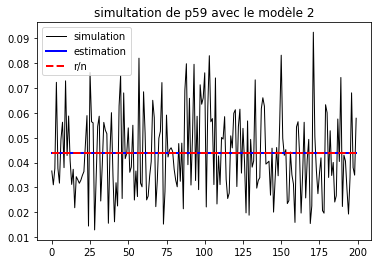

In [97]:
# trace de pj
j = 59

plt.plot(arr_p[::10,[j]], color = 'black', linewidth=1, label='simulation')
plt.plot([np.mean(arr_p[:,[j]])]*int(n_pts/10),'b-', linewidth=2, label = 'estimation')
plt.plot([data[j,0]/data[j,1]]*int(n_pts/10),'r--', linewidth=2, label = 'r/n')
plt.legend()
plt.title("simultation de p"+str(j) + " avec le modèle 2")

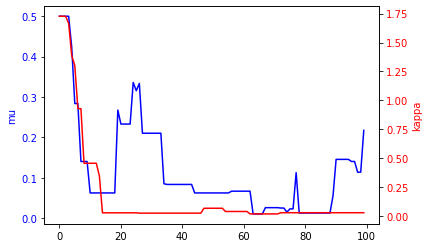

In [74]:
# traces de kappa et mu
fig, ax1 = plt.subplots()

ax1.plot(arr_mu[0:100], 'b-')
ax1.set_ylabel('mu', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(arr_kappa[0:100], 'r-')
ax2.set_ylabel('kappa', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.savefig('ShareAxes.png')
plt.show()

On peut noter qu'à la question 1 on suppose $\mu = 0.5$ et $\kappa = 2$

#### Autocorrélations

Text(0.5, 1.0, 'autocorrelation des simulations de mu')

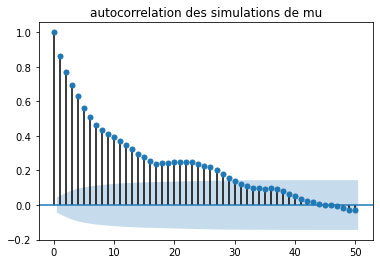

In [79]:
plot_acf(arr_mu, lags=50)
plt.title("autocorrelation des simulations de mu")

Text(0.5, 1.0, 'autocorrelation des simulations de kappa')

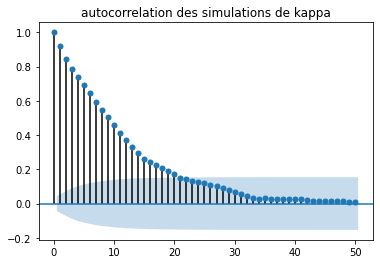

In [80]:
plot_acf(arr_kappa, lags=50)
plt.title("autocorrelation des simulations de kappa")

--> On choisit la variable *laps* égale à 30

### Estimation

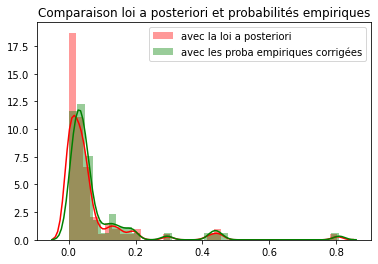

In [106]:
P, mu, kappa = estimation(n_pts, laps, mu=0.5, kappa = 0.1)

plt.title('Comparaison loi a posteriori et probabilités empiriques corrigées')
sns.distplot(P, color="red", kde=True)
sns.distplot(proba_positif_corrige, color="green", kde=True)
plt.legend(['avec la loi a posteriori', 'avec les proba empiriques corrigées'])

### Erreur Monte Carlo

L'erreur de Monte Carlo se calcule en effectuant un grand nombre de simulation et en calculant l'écart-type de la distribution des estimations

In [41]:
N_estim = 20  # Nombre d'estimateurs simulés pour le calcul de l'erreur
n_pts = 20    # Nombre de simulations Monte Carlo pour le calcul de chaque estimateur
laps = 30     # Nombre d'étapes de Metropolis-within-Gibbs entre deux points de simulation
              # --> au total on applique N_estim*n_pts*laps fois la fonction Metropolis_Gibbs()

arr_p, arr_mu, arr_kappa = np.zeros((N_estim,N_data)), np.zeros(N_estim), np.zeros(N_estim)

for i in tqdm(range(N_estim)) :
    arr_p[i], arr_mu[i], arr_kappa[i] = estimation(n_pts, laps, mu=0.5, kappa=2)
erreur_p = [np.sqrt(np.var(arr_p[:,[i]])) for i in range(N_data)]
erreur_mu = np.sqrt(np.var(arr_mu))
erreur_kappa = np.sqrt(np.var(arr_kappa))

100%|██████████| 20/20 [00:46<00:00,  2.33s/it]


valeur de mu : 0.21636788772288998
erreur sur mu : 0.06241001435180768
valeur de kappa : 0.038010369505207316
erreur sur kappa : 0.017849171955414606


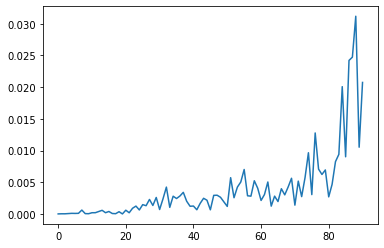

In [45]:
plt.plot(erreur_p)
print("valeur de mu : " + str(np.mean(arr_mu)) )
print("erreur sur mu : " + str(erreur_mu) )
print("valeur de kappa : " + str(np.mean(arr_kappa)) )
print("erreur sur kappa : " + str(erreur_kappa) )

## Question 3

<span style="color:red"> **LE CODE POUR CETTE SECTION N'EST PAS VALABLE** </span>

<span style="color:red"> voir le deuxième notebook </span>

Nous considérons un nouveau modèle : à présent les $p_i$ suivent un mélange de deux lois Beta, l'une de paramètres $(\alpha0, \beta0)$ l'autre de paramètres $(\alpha1, \beta1)$. On suppose que les $p_i$ suivent la loi 0 avec probabilité $q$ et la loi 1 avec probabilité $1-q$, $q$ étant fixé. 

Pour réaliser notre algorithme de Gibbs, nous associons à chaque pays une variable latente $z_i$ indiquant la loi suivie par $p_i$. $z_i$ suit à priori une loi de Bernouilli de paramètre $q$.

Les loi à posteriori de mu et kappa doivent tout d'abord être redéfinies pour tenir compte de la variable $z_i$
La loi a posteriori de $z_i$ doit être déterminée

#### Loi a posteriori de l'un des $p_i$ sachant $\mu$, $\kappa$, $z_i$ et les données :

En supposant un mélange de deux lois beta, on a :

$p_{i}| z_i,\mu,\kappa \sim Beta(r_{i}+\mu_{z_i}\kappa_{z_i} , n_{i}+\kappa_{z_i}(1-\mu_{z_i})-r_{i}) $

In [81]:
def Step_pi_mix(i,vect_z,mu,kappa) :
    r,n = data[i]
    z = vect_z[i]
    return np.random.beta(r + mu[z]*kappa[z], n - r + kappa[z]*(1-mu[z]))

#### Loi a posteriori de $\mu$ sachant $\kappa$, les vecteurs des $p_i$ et des $z_i$ et les données :

$\pi_{\mu | \kappa, p, z} \propto \prod_i \big( \frac{p_i}{1-p_i} \big) ^{\kappa_0\mu_0(1-z_i) + \kappa_1\mu_1 z_i} $

In [82]:
def log_loi_mu_mix(vect_p, vect_z, mu, kappa) :
    res = [0,0]
    accept = [True,True]
    
    if mu[0]<=0 or mu[0]>=1 :
        accept[0] = False
        
    if mu[1]<=0 or mu[1]>=1 :
        accept[1] = False
        
    for i in range(N_data) :
        p = vect_p[i]
        if p < 10**(-15) :
            res[vect_z[i]] += -15*kappa[vect_z[i]]*mu[vect_z[i]]
        else :
            res[vect_z[i]] += kappa[vect_z[i]]*mu[vect_z[i]]*(np.log(p) - np.log(1-p))
            
    return [accept, res]

In [83]:
def Metropolis_step_mu_mix(vect_p, vect_z, mu, kappa) :

    local_mu = mu
    # simulation d'un nouveau mu à partir du premier
    mu_new = [np.random.normal(mu[0], 0.01), np.random.normal(mu[1], 0.01)]
    
    Loi = log_loi_mu_mix(vect_p, vect_z, mu_new, kappa)
    Loi_old = log_loi_mu_mix(vect_p, vect_z, mu, kappa)
    
    if Loi[0][0] :
        log_taux_acceptation0 = Loi[1][0] - Loi_old[1][0]
        
        if np.log(np.random.random()) <= log_taux_acceptation0:
            #print("mu accept")
            local_mu[0] = mu_new[0]
            
    if Loi[0][1] : 
        log_taux_acceptation1 = Loi[1][1] - Loi_old[1][1]
           
        if np.log(np.random.random()) <= log_taux_acceptation1:
            #print("mu accept")
            local_mu[1] = mu_new[1]
            
    return local_mu

#### Loi a posteriori de $\kappa$ sachant $\mu$, les vecteurs des $p_i$, $z_i$ et les données :

$\pi_{\kappa | \mu, p, z} \propto \big( \prod_i 
    p_i^{\kappa_0\mu_0(1-z_i) + \kappa_1\mu_1 z_i}
    (1-p_i)^{\kappa_0(1-\mu_0)(1-z_i) + \kappa_1(1-\mu_1)z_i} 
    \exp^{-0.1(\kappa_0(1-z_i) + \kappa_1z_i)}\big) $

In [84]:
def log_loi_kappa_mix(vect_p, vect_z, mu, kappa) :
    res = [0,0]
    accept = [True, True]
    
    if kappa[0]<=0 :
        accept[0] = False
        
    if kappa[1]<=0 :
        accept[1] = False
        
    for i in range(N_data) :
        p = vect_p[i]
        if p<10**(-15) :
            res[vect_z[i]] += -15*kappa[vect_z[i]]*mu[vect_z[i]]
        else :
            res[vect_z[i]] += kappa[vect_z[i]]*mu[vect_z[i]]*np.log(p) + kappa[vect_z[i]]*(1-mu[vect_z[i]])*np.log(1-p)
        res[vect_z[i]] -= 0.1*kappa[vect_z[i]]/N_data
        
    return (accept, res)

In [85]:
def Metropolis_step_kappa_mix(vect_p, vect_z, mu, kappa) :

    local_kappa = kappa
    # simulation d'un nouveau kappa à partir du premier
    kappa_new = [np.random.normal(kappa[0], 0.05), np.random.normal(kappa[1], 0.05)]
    
    Loi = log_loi_kappa_mix(vect_p, vect_z, mu, kappa_new)
    Loi_old = log_loi_kappa_mix(vect_p, vect_z, mu, kappa)
        
    if Loi[0][0] :
        log_taux_acceptation0 = Loi[1][0] - Loi_old[1][0]
            
        if np.log(np.random.random()) <= log_taux_acceptation0:
            #print("kappa accept")
            local_kappa[0] = kappa_new[0]
            
    if Loi[0][1] :
        log_taux_acceptation1 = Loi[1][1] - Loi_old[1][1]
            
        if np.log(np.random.random()) <= log_taux_acceptation1:
            #print("kappa accept")
            local_kappa[1] = kappa_new[1]
    
    return local_kappa

#### Loi a posteriori de $z_i$ sachant $\mu$, $\kappa$, le vecteur des $p_i$ et les données :

$P(z_i = x | \mu, \kappa, p) \propto p_i ^{\mu_x  \kappa_x} (1-p_i) ^{(1-\mu_x)\kappa_x} q^x (1-q)^{1-x}
$

On en déduit que $z_i \sim B(q_i)$ avec $q_i = p_i^{\mu_1\kappa_1 - \mu_0 \kappa_0} (1-p_i)^{(1-\mu_1)\kappa_1 - (1-\mu_0)\kappa_0} \frac{q}{1-q}$

In [86]:
def Step_zi_mix(i, vect_p, mu, kappa, q) :
    
    if np.abs(mu[1]*kappa[1]-mu[0]*kappa[0]) < 10**8 or np.abs((1-vect_p[i])**((1-mu[1])*kappa[1]-(1-mu[0])*kappa[0])) < 10**8 :
        qi = q
    else :
        qi = ( vect_p[i]**(mu[1]*kappa[1]-mu[0]*kappa[0]) ) * ( (1-vect_p[i])**((1-mu[1])*kappa[1]-(1-mu[0])*kappa[0]) )
        
    return int(np.random.random()<qi)

### Simulation

In [87]:
def Metropolis_Gibbs_mix(mu, kappa, vect_z, q) :
    ## ici mu et kappa sont des couples contenant les valeurs 0 et 1 des paramètres
    
    vect_p = np.zeros(N_data)
    vect_z_new = vect_z
    
    for i in range(N_data) :
        vect_p[i] = Step_pi_mix(i,vect_z,mu, kappa)
        vect_z_new[i] = Step_zi_mix(i, vect_p, mu, kappa, q)
    
    mu_new = Metropolis_step_mu_mix(vect_p, vect_z, mu, kappa)
    kappa_new = Metropolis_step_kappa_mix(vect_p, vect_z, mu, kappa)
    
    return (vect_p,vect_z_new,mu_new,kappa_new)

In [88]:
def simulation_mix(n_pts, laps, mu = [0.5, 1], kappa = [0.1,0.5], q=0.5) :

    liste_p = []
    liste_z = []
    liste_mu = []
    liste_kappa = []
    
    sim_mu = mu
    sim_kappa = kappa
    sim_z = [int(x) for x in np.random.rand(N_data)<q]

    compte = 0

    for i in range(n_pts*laps) :
    
        sim_p, sim_z, sim_mu, sim_kappa = Metropolis_Gibbs_mix(sim_mu, sim_kappa, sim_z, q)
    
        if compte%laps == 0 :
            liste_p.append(sim_p)
            liste_z.append(sim_z)
            liste_mu.append(sim_mu)
            liste_kappa.append(sim_kappa)
        compte+=1
    
    return (np.array(liste_p), np.array(liste_mu), np.array(liste_kappa))

In [89]:
def estimation_mix(n_pts, laps, mu=[0.5, 1], kappa = [0.1, 0.5], q=0.5) :
    arr_p, arr_mu, arr_kappa = simulation_mix(n_pts, laps, mu, kappa, q)
    
    P = np.zeros(N_data)
    mu = 0
    kappa = 0
    
    for i in range(n_pts) :
        for j in range(N_data) :
            P[j] += arr_p[i][j]/n_pts
        mu += arr_mu[i]/n_pts
        kappa += arr_kappa[i]/n_pts
    
    return (P,mu,kappa)

In [99]:
n_pts = 100
laps = 1

In [100]:
arr_p, arr_mu, arr_kappa = simulation_mix(n_pts, laps)

Text(0.5, 1.0, 'simultation de p59 avec le modèle 3')

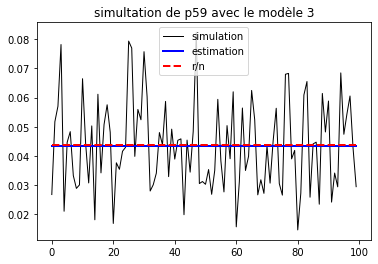

In [101]:
# trace de pj
j = 59

plt.plot(arr_p[:,[j]], color = 'black', linewidth=1, label='simulation')
plt.plot([np.mean(arr_p[:,[j]])]*int(n_pts),'b-', linewidth=2, label = 'estimation')
plt.plot([data[j,0]/data[j,1]]*int(n_pts),'r--', linewidth=2, label = 'r/n')
plt.legend()
plt.title("simultation de p"+str(j) + " avec le modèle 3")

(array([  0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.]),
 array([-4.99608021e-01, -3.99608021e-01, -2.99608021e-01, -1.99608021e-01,
        -9.96080213e-02,  3.91978658e-04,  1.00391979e-01,  2.00391979e-01,
         3.00391979e-01,  4.00391979e-01,  5.00391979e-01]),
 <a list of 10 Patch objects>)

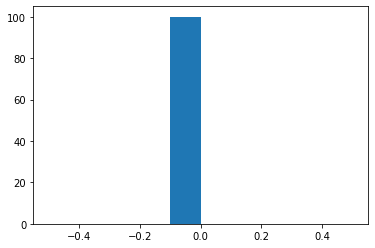

In [102]:
plt.hist(arr_kappa[:,[0]])